# Tendon Steering

The body of the robot is steered using 3 tendons, evenly spaced around the body. These tendons allow for steering in all directions. They are controlled using stepper motors and spools.

## Modeling

Controlling the tendons is relatively simple. There is an equation to represent the steering from [this](https://par.nsf.gov/servlets/purl/10100241) paper:
$$
l_i=l-\theta(D_{tube}/2)cos(\phi_i)
$$

| Variable   | Description                   |
|------------|-------------------------------|
| $l_i$      | Tendon Length (meters)        |
| $l$        | Body Length (meters)          |
| $\theta$   | Curvature (radians per meter) |
| $D_{tube}$ | Body Diameter (meters)        |
| $\psi_i$   | Difference between steering direction and tendon position |

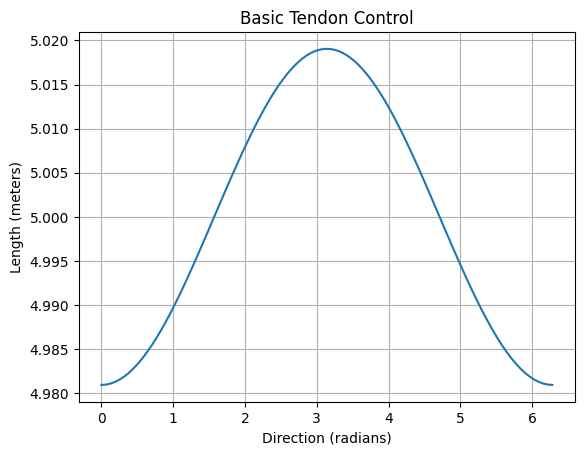

In [18]:
import matplotlib.pyplot as plt
import numpy as np

LENGTH = 5
CURVATURE = 0.5
BODY_DIAMETER = 0.0762 # 3 inches
TENDON_POSITION = 0

def basic_tendon_control(
    steering_direction: float,
    length: float = LENGTH,
    curvature: float = CURVATURE,
    body_diameter: float = BODY_DIAMETER,
    tendon_position: float = TENDON_POSITION
) -> float:
    return length - (curvature * (body_diameter / 2) * np.cos(tendon_position - steering_direction))

x = np.linspace(0, 2 * np.pi, 100)
plt.plot(x, basic_tendon_control(x))
plt.title("Basic Tendon Control")
plt.xlabel('Direction (radians)')
plt.ylabel('Length (meters)')
plt.grid()
plt.show()

This works great (kinda), but could be better for my application. So, by doing some math we can get this:
$$
\Delta l_i=\frac{\theta(D_{tube}/2)cos(\psi_i-\phi)}{R_{spool}}
$$
This equation gets the *difference* in tendon position, and removes the need to know the length, and includes the tendon spool diameter to get the result in radians. Its graph looks more like this:

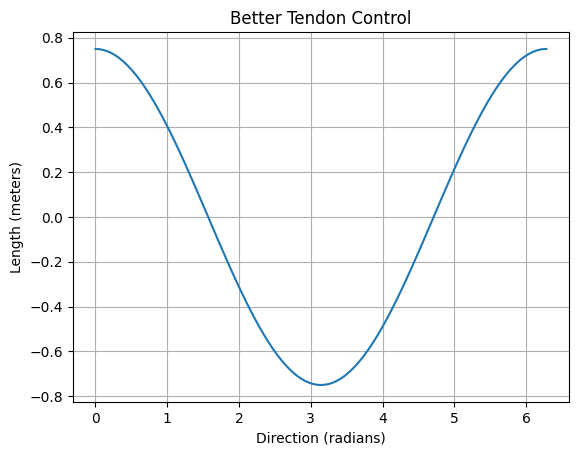

In [23]:
# CURVATURE = 0.05
# BODY_DIAMETER = 0.0762 # 3 inches
# TENDON_POSITION = 0
TENDON_SPOOL_RADIUS = 0.0254

def better_tendon_control(
    steering_direction: float,
    curvature: float = CURVATURE,
    body_diameter: float = BODY_DIAMETER,
    tendon_position: float = TENDON_POSITION,
    tendon_spool_radius: float = TENDON_SPOOL_RADIUS,
) -> float:
    return (curvature * body_diameter / 2 * np.cos(tendon_position - steering_direction)) / tendon_spool_radius

x = np.linspace(0, 2 * np.pi, 100)
plt.plot(x, better_tendon_control(x))
plt.title("Better Tendon Control")
plt.xlabel('Direction (radians)')
plt.ylabel('Length (meters)')
plt.grid()
plt.show()

We can see that the needed position is higher when the direction is facing towards the tendon, and lower when further away. This is close to what we need, but backwards. We can fix this by just multiplying by -1.

## Interface

Before we can use this, we have to convert the controller inputs to curvatures. We can do this using polar coordinates, where the radius is the curvature and $\theta$ is the direction. The controller outputs and x and y value from -1 to 1, so the conversion looks like this:

In [ ]:
def cartesian_to_polar(x: float, y: float) -> tuple[float, float]:
    rho = np.sqrt(x**2 + y**2)  # R
    phi = np.arctan2(y, x)  # Theta
    return (phi, rho)